## Goal
Apply DBScan Clustering on Amazon Food reviews
1. Remove y_i_s.
2. Featurize/Vectorize - Average Word2Vec, tfIDF Word2Vec
3. Try with Minpts as 2*d
4. Use elbow method to determine the correct eps.
    - Use pairwise distances to compute a distance matrix
    - Sort the distance matrix
    - Plot the Minpts neigbors plot
5. Represent the clusters in a word cloud.
5. After determining the correct eps try other eps around the correct eps determined in step4 because DBScan is sensitive to hyperparams especially eps to get an understanding as to how that affects the clusters.


### Data
The Amazon fine food reviews dataset is available [here](https://www.kaggle.com/snap/amazon-fine-food-reviews/downloads/database.sqlite/2). The SQLLite version(database.sqlite) of the dataset is used. A folder called 'amazon-fine-food-reviews' needs to be created in the working directory and downloaded to that folder.

Google Word2Vec (GoogleNews-vectors-negative300.bin) is also used and those are available [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise

from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, f1_score, classification_report, make_scorer, roc_curve, auc
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD

import itertools, pickle, random, sqlite3, nltk, string, re
from pathlib import Path
from scipy import sparse
import scipy as sp

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec, KeyedVectors
from tqdm import tqdm
from datetime import datetime, timedelta

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Load Data

In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not considering those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

In [4]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#change reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print ('Total number of reviews is {} with {} features each'.format(*filtered_data.shape))
filtered_data.head()

Total number of reviews is 525814 with 10 features each


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### EDA

#### Remove Duplicates

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

#### Data Cleanup

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

#### Note:
The dataset is imbalanced. So the metric to evaluate the model should not be accuracy, it could be confusion matrix 

### PreProcessing

#### Stemming, Stop word remove and Lemmatization

In [7]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print('The stop words are \n {}'.format(stop))
print('************************************************************')
print('The stem word for tasty is {}'.format(sno.stem('tasty')))

The stop words are 
 {'this', 'myself', 'how', "shouldn't", 'any', 'no', 'o', 'be', 'of', 'with', 'does', 'me', "couldn't", 'because', 'off', 'which', 'doesn', 'that', 'each', 'we', "needn't", 'our', 'a', 'he', "doesn't", 'these', 'm', "won't", 'same', "isn't", 'themselves', 'such', 'both', 't', 'yours', 'wouldn', 'only', 'mightn', "you're", 'ours', 'did', 'most', "that'll", 'isn', 'own', "weren't", "don't", 'what', 'ourselves', 'there', 'it', 'against', 'you', 'if', "wasn't", 'is', 'why', 'are', 'out', 'theirs', 'mustn', 'needn', 'ain', "shan't", 'should', 'by', 'his', 'who', 'am', 'my', 'about', 'below', 'more', 'ma', 'while', 'her', 'those', 'here', 'or', 'shouldn', 'other', 'll', 'some', 'before', "should've", 'd', 'to', 'couldn', 'then', 'whom', 'your', 'over', 'himself', 'him', 'in', 'into', 'as', 'were', 're', 'few', 'further', 'shan', 'up', 'under', "mustn't", 'until', "she's", 'than', 'aren', 'weren', 'hers', 'has', 'once', 'all', 'now', 'having', 'they', 'on', 'when', 'the', 

We need 3 types of cleaned data so we will use 3 different variables to store this data:
1. For Bag of Words and TfIDF we need the stop words to be removed and stemmed
2. For Bigrams and trigrams we do not need to remove the stop words but we can stem the words
3. For Avg Word2Vec and TfIDF Word2Vec we can remove the stopwords but not stem the words if we plan to use Google's word2vec model.

In [10]:
i=0
str_b=' '
str_n=' '
str_w=' '
bow_tfidf_string=[]
ngrams_string=[]
word2vec_string=[]
s=''
for sent in final['Text'].values:
    filtered_sentence_b=[]
    filtered_sentence_n=[]
    filtered_sentence_w=[]
    
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)): 
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence_n.append(s) #for ngrams we need stemmed words
                if(cleaned_words.lower() not in stop):
                    filtered_sentence_b.append(s) #for BoW and tfidf we need stemmed and stop words removed data
                    filtered_sentence_w.append(cleaned_words.lower().encode('utf8')) # for Word2Vec we need non stemmed and stop words removed data
                else:
                    continue
            else:
                continue 
    
    
    str_n = b" ".join(filtered_sentence_n)
    str_b = b" ".join(filtered_sentence_b)
    str_w = b" ".join(filtered_sentence_w)
    
    bow_tfidf_string.append(str_b)
    ngrams_string.append(str_n)
    word2vec_string.append(str_w)

    i+=1

In [11]:
final['BowTfIDFText']=bow_tfidf_string 
final['BowTfIDFText']=final['BowTfIDFText'].str.decode("utf-8")

# final['nGramsText']=ngrams_string 
# final['nGramsText']=final['nGramsText'].str.decode("utf-8")

final['Word2VecText']=word2vec_string 
final['Word2VecText']=final['Word2VecText'].str.decode("utf-8")

In [12]:
# store final table into an SQlLite table for future.
final_dbconn = sqlite3.connect('./amazon-fine-food-reviews/finaldb.sqlite')
c=final_dbconn.cursor()
final_dbconn.text_factory = str
final.to_sql('Reviews', final_dbconn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

### Run Classifier

In [2]:
def nearest_neighbors(X, k):
    
    #create pairwise distances. This will create a nxn matrix
    distances = pairwise.pairwise_distances(X)
    
    #inplace sort
    distances.sort()
    
    #get all the 2-NN
    k_nn = distances[:, k-1]
    k_nn.sort()

    # Plot the elbow
    plt.plot(k_nn, 'bx-')

    plt.xlabel('Point Index')
    plt.ylabel('Distance')

    plt.title('The Elbow Method showing the optimal epsilon')
    plt.grid()

    plt.show()

In [3]:
def plot_word_cloud(file_name, title, word_cloud_column):
    if not file_name or not title or not word_cloud_column:
        print ('file_name, title and word_cloud_column are mandatory parameters')
        return
    
    df = pd.read_csv(file_name, encoding ="latin-1") 
    df = df.drop(df[df.ClusterID==-1].index)

    comment_words = ' '
    stopwords = set(STOPWORDS) 

    for i in range(df.ClusterID.nunique()):
        wordcloud = WordCloud(width = 800, height = 800, 
                        background_color ='white', 
                        stopwords = stopwords, 
                        min_font_size = 10).generate(str(df[df.ClusterID == i][word_cloud_column])) 

        # plot the WordCloud image                        
        plt.figure(figsize = (8, 8), facecolor = None) 
        plt.title(title + ' ' + str(i))
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 

        plt.show() 

In [4]:
def run_model(eps, minpts, X, data, file_name, word_cloud_title):
    #since DBScan is sensitive to hyperparameters, especially epsilon
    #trying with different epsilons around the one that we got using the elbow method
#     epsilons = [eps-1, eps, eps+1]
    epsilons = [eps]
    for eps in epsilons:
        print('Creating model with eps {}....'.format(eps))
        model = DBSCAN(eps=eps, min_samples=minpts, n_jobs=-1).fit(X)
        csv_file_name = './amazon-fine-food-reviews/' + file_name + '-' + str(eps) + '-eps.csv'
        print ('Clusters with eps of {} are {}'.format(eps, model.labels_))
        data['ClusterID']=model.labels_ 
        data.to_csv(csv_file_name, index=False)
        
    word_cloud_column = 'Word2VecText'
    for eps in epsilons:
        print('Creating word cloud with eps {}....'.format(eps))
        csv_file_name = './amazon-fine-food-reviews/' + file_name + '-' + str(eps) + '-eps.csv'
        title= word_cloud_title + ' - eps -' + str(eps) + ' - Cluster'
        plot_word_cloud(csv_file_name, title, word_cloud_column)

## Word2Vec
There are 2 ways to do word2vec
1. Use Google's model which was built using Google's news dataset. Since this was built from a large dataset, this gives us a 300 dimension vector which will be richer.
2. Train our own model. Since we have a small dataset, we can build a 50 dimensional vector with this.
We will try both ways below

As a first step we need to build a list of sentence from the Word2VecText we have saved earlier. This will be used to get the vectors from Google's model as well as the one that we are going to build

In [4]:
def get_w2vdata(no_of_records = 2000, split_evenly=True):
    if split_evenly:
        pos_limit = int(no_of_records * 0.50)
        neg_limit = no_of_records - pos_limit
    else:
    #The original dataset has approximately 85% positive reviews and 15% negative reviews, so we will use the same % to make
    #a subset 
        pos_limit = int(no_of_records * 0.85)
        neg_limit = no_of_records - pos_limit

    final_dbconn = sqlite3.connect('./amazon-fine-food-reviews/finaldb.sqlite')
    final_dbconn.text_factory = str

    pos_qry = "SELECT Text, Word2VecText, Score FROM Reviews where Score = 'positive' LIMIT " + str(pos_limit)
    pos_reviews = pd.read_sql_query(pos_qry, final_dbconn) 
    print('Positive reviews shape is {}'.format(pos_reviews.shape))

    neg_qry = "SELECT Text, Word2VecText, Score FROM Reviews where Score = 'negative' LIMIT " + str(neg_limit)
    neg_reviews = pd.read_sql_query(neg_qry, final_dbconn) 
    print('Negative reviews shape is {}'.format(neg_reviews.shape))

    frames = [pos_reviews, neg_reviews]

    data = pd.concat(frames, ignore_index=True)
    print('Both positive and negative reviews combined together contains {} reviews'.format(data.shape[0]))

    return data

#### Train our own Word2Vec model

In [5]:
def build_word2vec(train_list_of_sent):
    # Train your own Word2Vec model using your own text corpus
    w2v_model=Word2Vec(train_list_of_sent,min_count=5,size=50, workers=4)

    w2v_words = list(w2v_model.wv.vocab)
    return w2v_model, w2v_words

#### Average Word2Vec With our own model

In [6]:
def vectorize_Oavgw2v(X):
    list_of_sent=[]
    
    print ('Splitting data into sentences.....')
    for sent in X['Word2VecText'].values:
        list_of_sent.append(sent.split())
    
    print ('Building our word model.....')
    w2v_model, w2v_words = build_word2vec(list_of_sent)

    print ('Vectorizing train data.....')
    print('Starting vectorizing at {}'. format(datetime.now()))
    
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)

    print('Completed vectorizing at {}'. format(datetime.now()))
    
    #convert to sparse matrix
    X_counts = sparse.csr_matrix(np.array(sent_vectors))
            
    X_std_data = StandardScaler(with_mean = False).fit_transform(X_counts)
    print ('Type of std_bow_data is {}'.format(type(X_std_data)))
    print ('Standardized reviews contain {} reviews with {} features each'.format(*X_std_data.shape))
    
    return X_std_data

08:15:44
Positive reviews shape is (25000, 3)
Negative reviews shape is (25000, 3)
Both positive and negative reviews combined together contains 50000 reviews
Splitting data into sentences.....
Building our word model.....
Vectorizing train data.....
Starting vectorizing at 2018-11-18 08:15:49.504380
Completed vectorizing at 2018-11-18 08:16:55.511566
Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized reviews contain 50000 reviews with 50 features each
08:16:55
Creating nearest neighbors....


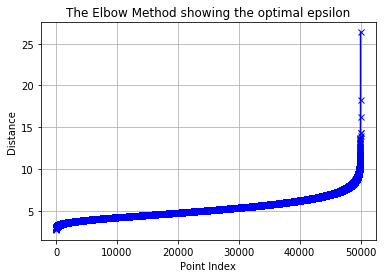

08:38:22


In [8]:
no_of_records=50000
print (format(datetime.now(), '%H:%M:%S'))
data = get_w2vdata(no_of_records)
X = vectorize_Oavgw2v(data)
minpts = X.shape[1] * 2

print (format(datetime.now(), '%H:%M:%S'))
print('Creating nearest neighbors....')
nearest_neighbors(X, minpts)
# X=run_classifier(data, vectorize_technique ='Oavgw2v')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))

In [7]:
#mark the eps that we got from the above elbow method - distance indicates the eps to be used
eps=9

no_of_records=50000
print (format(datetime.now(), '%H:%M:%S'))
data = get_w2vdata(no_of_records)
X = vectorize_Oavgw2v(data)
minpts = X.shape[1] * 2

file_name = 'DBScan-AvgW2V'
word_cloud_title='Word Cloud of AvgW2V'

# run_model(eps, minpts, X, data, file_name, word_cloud_title)

12:53:06
Positive reviews shape is (25000, 3)
Negative reviews shape is (25000, 3)
Both positive and negative reviews combined together contains 50000 reviews
Splitting data into sentences.....
Building our word model.....
Vectorizing train data.....
Starting vectorizing at 2018-11-18 12:53:50.047493
Completed vectorizing at 2018-11-18 12:54:56.286239
Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized reviews contain 50000 reviews with 50 features each


In [ ]:
print('Creating model with eps {}....'.format(eps))
model = DBSCAN(eps=eps, min_samples=minpts, n_jobs=-1).fit(X)

# csv_file_name = './amazon-fine-food-reviews/' + file_name + '-' + str(eps) + '-eps.csv'
# print ('Clusters with eps of {} are {}'.format(eps, model.labels_))
# data['ClusterID']=model.labels_ 
# data.to_csv(csv_file_name, index=False)
        
# word_cloud_column = 'Word2VecText'
# print('Creating word cloud with eps {}....'.format(eps))
# csv_file_name = './amazon-fine-food-reviews/' + file_name + '-' + str(eps) + '-eps.csv'
# title= word_cloud_title + ' - eps -' + str(eps) + ' - Cluster'
# plot_word_cloud(csv_file_name, title, word_cloud_column)

Creating model with eps 9....


Exception in thread Thread-33:
Traceback (most recent call last):
  File "d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\multiprocessing\pool.py", line 463, in _handle_results
    task = get()
  File "d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\multiprocessing\connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\multiprocessing\connection.py", line 318, in _recv_bytes
    return self._get_more_data(ov, maxsize)
  File "d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\multiprocessing\connection.py", line 337, in _get_more_data
    assert left > 0
AssertionError



#### TF-IDF weighted Word2Vec With our own model

In [12]:
def vectorize_Otfidfw2v(X):
    # TF-IDF weighted Word2Vec
    tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
    tf_idf_counts = tf_idf_vect.fit_transform(X['Word2VecText'].values)
    
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))


    tfidf_feat = tf_idf_vect.get_feature_names() 
    
    list_of_sent=[]
    
    print ('Splitting train data into sentences.....')
    for sent in X['Word2VecText'].values:
        list_of_sent.append(sent.split())
    
    print ('Building our word model.....')
    w2v_model, w2v_words = build_word2vec(list_of_sent)
    
    print ('Vectorizing data.....')
    sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in list_of_sent: # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
#                 tf_idf = tf_idf_counts[row, tfidf_feat.index(word)]
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        sent_vectors.append(sent_vec)
        row += 1

    X_counts = sparse.csr_matrix(np.array(sent_vectors))
        
    X_std_data = StandardScaler(with_mean = False).fit_transform(X_counts)
    print ('Type of std_bow_data is {}'.format(type(X_std_data)))
    print ('Standardized reviews contain {} reviews with {} features each'.format(*X_std_data.shape))
    
    return X_std_data

In [ ]:
no_of_records=150000
print (format(datetime.now(), '%H:%M:%S'))

data = get_w2vdata(no_of_records)
X = vectorize_Otfidfw2v(data)
minpts = X.shape[1] * 2

print (format(datetime.now(), '%H:%M:%S'))
print('Creating nearest neighbors....')
nearest_neighbors(X, minpts)

ist = datetime.now()
print (format(ist, '%H:%M:%S'))

Clusters with eps of 5 are [0 0 0 ... 0 0 0]
Clusters with eps of 6 are [0 0 0 ... 0 0 0]
Clusters with eps of 7 are [0 0 0 ... 0 0 0]
Clusters with eps of 8 are [0 0 0 ... 0 0 0]
Clusters with eps of 9 are [0 0 0 ... 0 0 0]


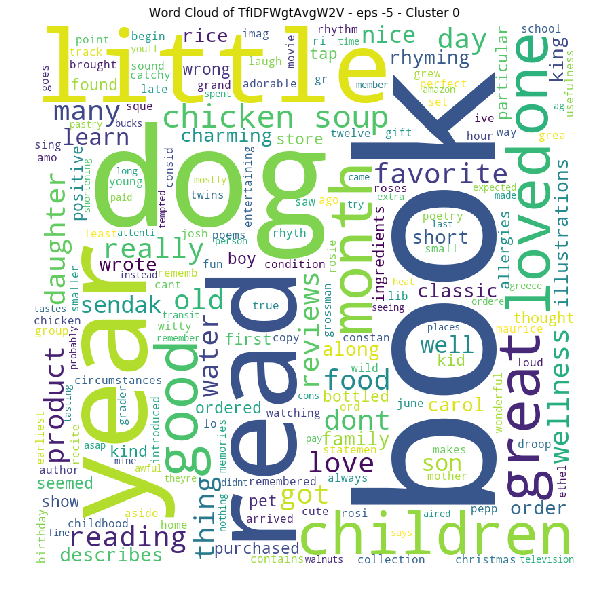

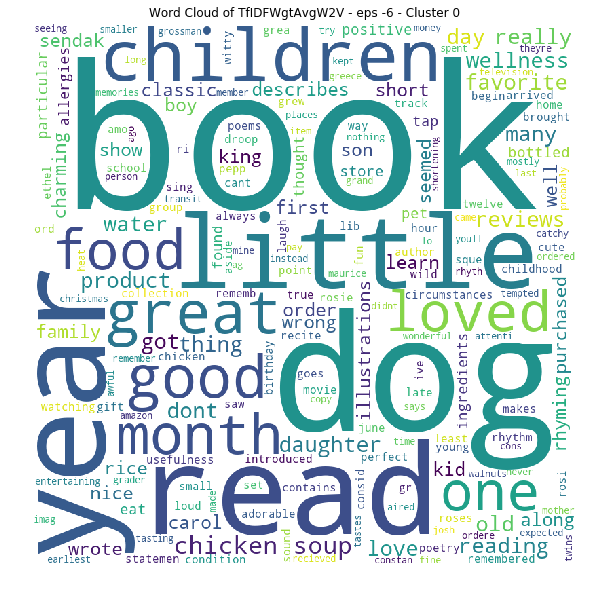

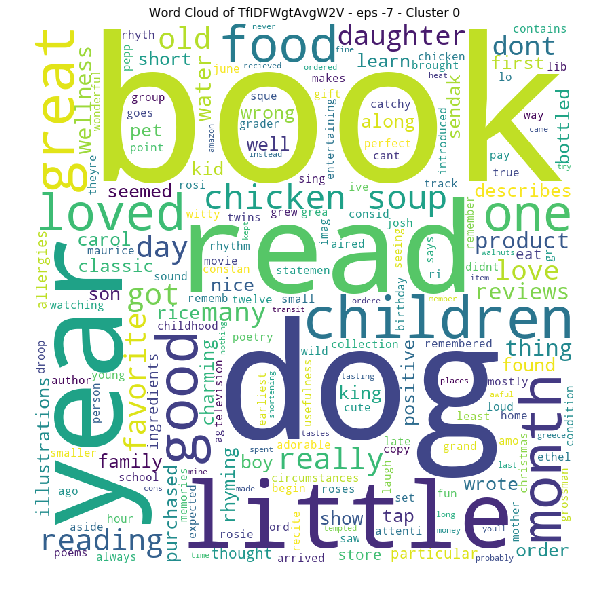

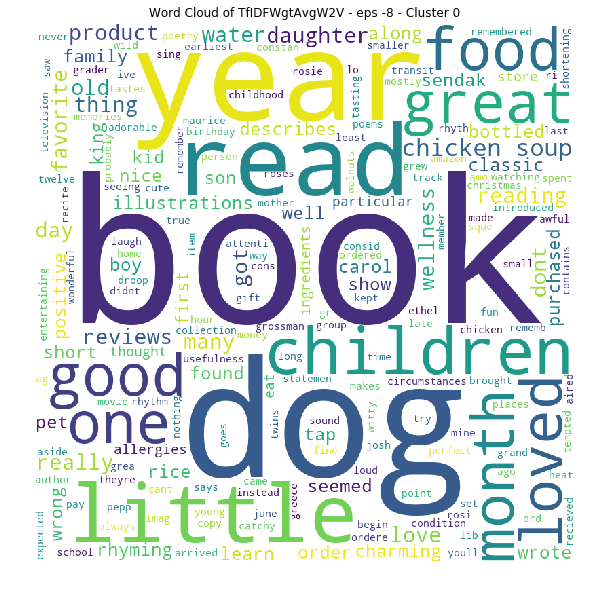

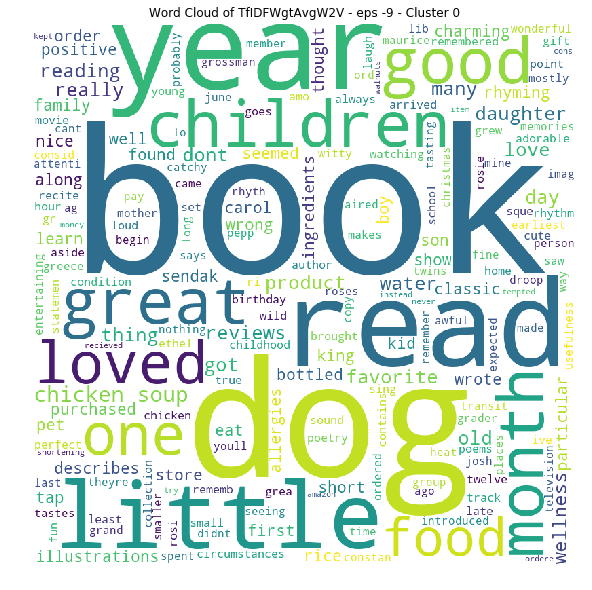

In [19]:
#mark the eps that we got from the above elbow method - distance indicates the eps to be used
eps=7
file_name = 'DBScan-TfIDFWgtAvgW2V'
word_cloud_title='Word Cloud of TfIDFWgtAvgW2V'

run_model(eps, minpts, X, data, file_name, word_cloud_title)